# GAMMA RAY BURSTS
We know that the there are two sources of GRBs. So we expect to find two clusters in the data.
The main distinction between the two is the time: one astrophysical source emits shorter GRBs with respect to the other. So the first thing we would like to do is look at the duration to see if we can see two modes:

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

[]

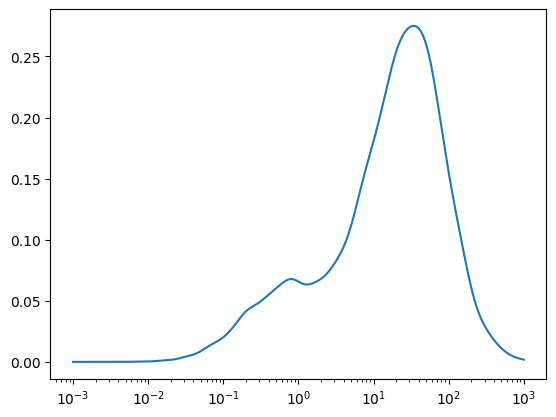

In [4]:
T90 = np.array(data[6, :], dtype = float)
T90_pos = T90[T90[:] > 0.0]

def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(kernel='gaussian', bandwidth = bandwidth)
    kde_skl.fit(np.log(data[:, np.newaxis]))
    log_pdf = kde_skl.score_samples(np.log(xgrid[:, np.newaxis])) # sklearn returns log(density)
    return np.exp(log_pdf)

bw_range = np.linspace(0.01, 0.5, 20)
grid = GridSearchCV(KernelDensity(), {'bandwidth':bw_range}, cv = 5)
grid.fit(np.log(T90_pos[:, np.newaxis]))
b_opt = grid.best_params_['bandwidth']

xgrid = np.logspace(-3, 3, 1000)
pdf = kde_sklearn(T90_pos, b_opt)
plt.plot(xgrid, pdf)
plt.semilogx()

We can see two modes. Now we can try to split the data into two clusters. We use the K-means algorithm first:

In [5]:
cl_km = KMeans(n_clusters=2)
cl_km.fit(np.log(T90_pos)[:, np.newaxis])
labels_km = cl_km.predict(np.log(T90_pos)[:, np.newaxis])

if cl_km.cluster_centers_[0] < cl_km.cluster_centers_[1]:
    short = 0
    long = 1
else:
    short = 1
    long = 0

thr_km = np.mean([np.max(T90_pos[labels_km == short]), np.min(T90_pos[labels_km == long])])
print("The estimated threshold between short and long GRBs: {:.3f} s".format(thr_km))

The estimated threshold between short and long GRBs: 5.470 s


Then we can try to use the Mean-Shift algorithm, to see if it gives a different result.

In [6]:
bandwidth = estimate_bandwidth(np.log(T90_pos)[:, np.newaxis])
cl_ms = MeanShift(bandwidth=1.0, bin_seeding=True, cluster_all=False)
cl_ms.fit(np.log(T90_pos)[:, np.newaxis])
labels_ms = cl_ms.predict(np.log(T90_pos)[:, np.newaxis])

if cl_km.cluster_centers_[0] < cl_km.cluster_centers_[1]:
    short = 0
    long = 1
else:
    short = 1
    long = 0

thr_ms = np.mean([np.max(T90_pos[labels_ms == short]), np.min(T90_pos[labels_ms == long])])
print("The estimated threshold between short and long GRBs: {:.3f} s".format(thr_ms))

The estimated threshold between short and long GRBs: 1050.004 s


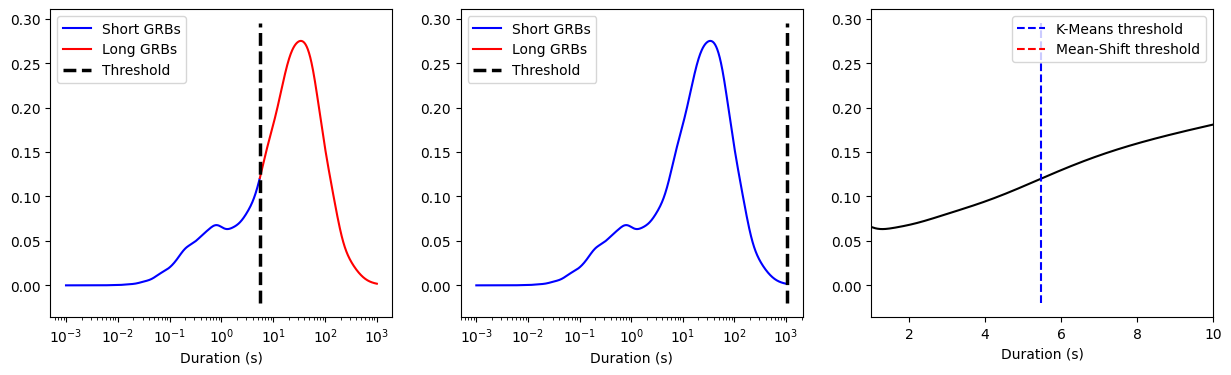

In [7]:
plt.figure(figsize=[15, 4])

plt.subplot(1, 3, 1)
plt.plot(xgrid[xgrid < thr_km], pdf[xgrid < thr_km], color = 'blue', label = "Short GRBs")
plt.plot(xgrid[xgrid >= thr_km], pdf[xgrid >= thr_km], color = 'red', label = "Long GRBs")
x_thr_km = np.full(1000, thr_km)
y_thr_km = np.linspace(np.min(pdf)-0.02, np.max(pdf) + 0.02, 1000)
plt.plot(x_thr_km, y_thr_km, ls='--', lw = 2.5, color = 'black', label = 'Threshold')
plt.xlabel("Duration (s)")
plt.legend()
plt.semilogx()

plt.subplot(1, 3, 2)
plt.plot(xgrid[xgrid < thr_ms], pdf[xgrid < thr_ms], color = 'blue', label = "Short GRBs")
plt.plot(xgrid[xgrid >= thr_ms], pdf[xgrid >= thr_ms], color = 'red', label = "Long GRBs")
x_thr_ms = np.full(1000, thr_ms)
y_thr_ms = np.linspace(np.min(pdf)-0.02, np.max(pdf) + 0.02, 1000)
plt.plot(x_thr_ms, y_thr_ms, ls='--', lw = 2.5, color = 'black', label = 'Threshold')
plt.xlabel("Duration (s)")
plt.legend()
plt.semilogx()

plt.subplot(1, 3, 3)
plt.plot(xgrid, pdf, color='black')
plt.plot(x_thr_km, y_thr_km, ls = '--', color = 'blue', label = 'K-Means threshold')
plt.plot(x_thr_ms, y_thr_ms, ls = '--', color = 'red', label = 'Mean-Shift threshold')
plt.xlim(1.0, 10.0)
plt.xlabel("Duration (s)")
plt.legend()

We can see that the two algorithm give comparable results.

Now that we have the model, we can see which is the probability of detecting a short/long GRB:

In [8]:
print("Probability of detecting a short GRB: {:.3f} %".format(len(T90_pos[T90_pos < thr_km])/len(T90_pos) * 100))
print("Probability of detecting a long GRB: {:.3f} %".format(len(T90_pos[T90_pos >= thr_km])/len(T90_pos) * 100))

Probability of detecting a short GRB: 25.794 %
Probability of detecting a long GRB: 74.206 %


So detecting a long GRB is about three times more probable with respect to a short one.

But is the duration the only variable that can discriminate between the two types of burst? To see if there are other combination of quantities, we plot some scatter plot. In particular, we plot the duration vs fluence, redshift vs fluence and duration vs redshift:

Text(0, 0.5, 'Redshift')

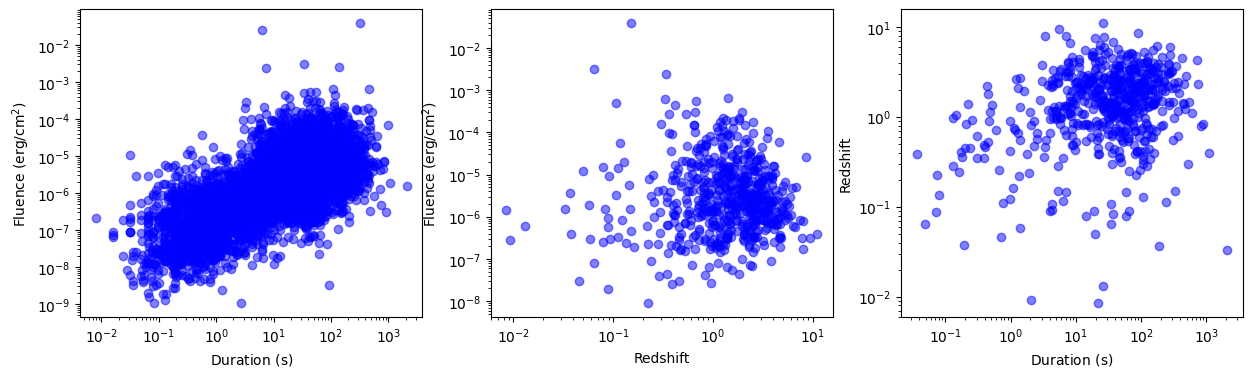

In [9]:
T90_vs_fluence = np.array([[data[6, i], data[9, i]] for i in range(len(data[0, :]))], dtype=float)
a = T90_vs_fluence[T90_vs_fluence[:,0] > 0.0]
T90_vs_f_pos = a[a[:, 1] > 0.0]

dist_vs_fluence = np.array([[data[11, i], data[9, i]] for i in range(len(data[0, :]))], dtype=float)
a = dist_vs_fluence[dist_vs_fluence[:, 1] > 0.0]
dist_vs_f_pos = a[a[:, 0] > 0.0]

T90_vs_dist = np.array([[data[6, i], data[11, i]] for i in range(len(data[0, :]))], dtype=float)
condition1 = (T90_vs_dist[:,0] > 0.0)
a = T90_vs_dist[T90_vs_dist[:,0] > 0.0]
T90_vs_dist_pos = a[a[:, 1] > 0.0]

plt.figure(figsize=[15, 4])
plt.subplot(1,3,1)
plt.scatter(T90_vs_f_pos[:, 0], T90_vs_f_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.subplot(1,3,2)
plt.scatter(dist_vs_f_pos[:, 0], dist_vs_f_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Redshift")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.subplot(1,3,3)
plt.scatter(T90_vs_dist_pos[:, 0], T90_vs_dist_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Redshift")

We can clearly see two modes in the first plot, indicating that the process that produces the shorter burts also produce the less energetic. Morover, neither the fluence nor the duration seem to depend on the distance, thus the relation between the two variables seems to be determined by the actual process undergoing.

Now we can try to find the two clusters of the couples (duration, fluence). The first approach is using the K-means algorithm:

In [10]:
clust = KMeans(n_clusters=2)
clust.fit(np.log(T90_vs_f_pos))
labels = clust.predict(np.log(T90_vs_f_pos))

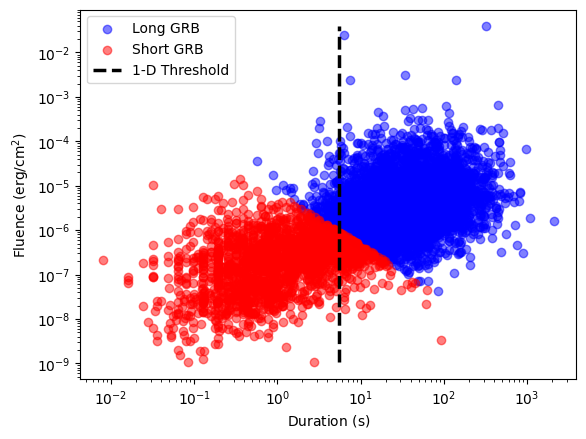

In [11]:
plt.scatter(T90_vs_f_pos[labels == 0, 0], T90_vs_f_pos[labels == 0, 1], c = 'blue', alpha = 0.5, label = "Long GRB")
plt.scatter(T90_vs_f_pos[labels == 1, 0], T90_vs_f_pos[labels == 1, 1], c = 'red', alpha = 0.5, label = "Short GRB")
f_thr_km = np.linspace(np.min(T90_vs_f_pos[:, 1]), np.max(T90_vs_f_pos[:, 1]), 1000)
plt.plot(x_thr_km, f_thr_km, color='black', ls='--', lw=2.5, label = "1-D Threshold")
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.legend()

Over the plot we see the threshold found before, considering only the duration. The fact that this is (at least qualitatively speaking) compatible with the new model gives us confidence about the construction.

We can compute again the probabilities of detection:

In [12]:
print("Probability of detecting a short GRB: {:.3f} %".format(len(T90_vs_f_pos[labels == 1][:, 0])/len(T90_vs_f_pos[:, 0]) * 100))
print("Probability of detecting a short GRB: {:.3f} %".format(len(T90_vs_f_pos[labels == 0][:, 0])/len(T90_vs_f_pos[:, 0]) * 100))

Probability of detecting a short GRB: 27.211 %
Probability of detecting a short GRB: 72.789 %


Quite similar to the old ones.